TP4: Régularisation et Algorithmes Proximaux
Sélection de gènes et Débruitage d'images
Optimisation pour l'Apprentissage Automatique 2025/2026

Solution complète avec visualisations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_olivetti_faces
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:

# Configuration pour de meilleurs graphiques
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*80)
print("TP4: RÉGULARISATION ET ALGORITHMES PROXIMAUX")
print("="*80)

TP4: RÉGULARISATION ET ALGORITHMES PROXIMAUX


In [3]:
# ============================================================================
# PARTIE 1: L'OPÉRATEUR DE SEUILLAGE DOUX (SOFT THRESHOLDING)
# ============================================================================

def soft_thresholding(v, gamma):
    """
    Opérateur proximal de la norme L1
    
    Args:
        v: vecteur ou scalaire
        gamma: paramètre de seuillage
    
    Returns:
        sign(v) * max(0, |v| - gamma)
    """
    return np.sign(v) * np.maximum(0, np.abs(v) - gamma)

print("\n" + "="*80)
print("EXERCICE 1: SOFT THRESHOLDING")
print("="*80)


EXERCICE 1: SOFT THRESHOLDING


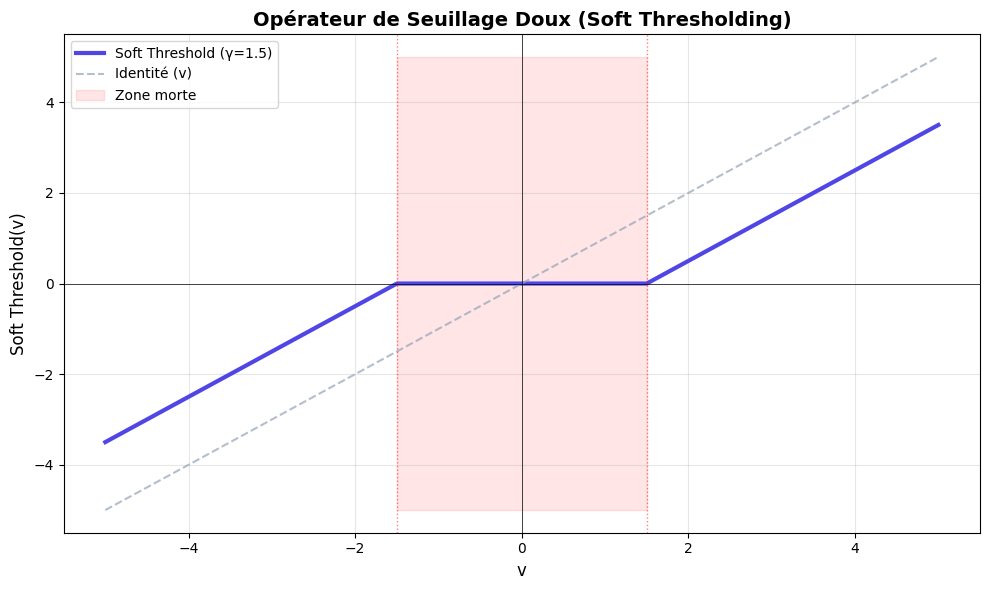


✓ Zone morte: [-1.50, 1.50]
✓ Dans cette zone, toutes les valeurs sont mises à 0
✓ Graphique sauvegardé: soft_thresholding.png


In [4]:
# Tracé de la fonction soft thresholding
v_values = np.linspace(-5, 5, 1000)
gamma = 1.5

plt.figure(figsize=(10, 6))
plt.plot(v_values, soft_thresholding(v_values, gamma), 
         linewidth=3, label=f'Soft Threshold (γ={gamma})', color='#4f46e5')
plt.plot(v_values, v_values, '--', linewidth=1.5, 
         label='Identité (v)', color='#94a3b8', alpha=0.7)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.axvline(x=-gamma, color='red', linewidth=1, linestyle=':', alpha=0.5)
plt.axvline(x=gamma, color='red', linewidth=1, linestyle=':', alpha=0.5)
plt.fill_between([-gamma, gamma], -5, 5, alpha=0.1, color='red', 
                 label='Zone morte')
plt.xlabel('v', fontsize=12)
plt.ylabel('Soft Threshold(v)', fontsize=12)
plt.title('Opérateur de Seuillage Doux (Soft Thresholding)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('soft_thresholding.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Zone morte: [{-gamma:.2f}, {gamma:.2f}]")
print(f"✓ Dans cette zone, toutes les valeurs sont mises à 0")
print(f"✓ Graphique sauvegardé: soft_thresholding.png")


In [5]:
# ============================================================================
# PARTIE 2: IMPLÉMENTATION DE ISTA
# ============================================================================

def generate_synthetic_data(n=100, d=50, sparsity=5, noise_std=0.5, seed=42):
    """
    Génère un dataset synthétique avec un vecteur w creux
    
    Args:
        n: nombre d'échantillons
        d: dimension (nombre de features)
        sparsity: nombre de coefficients non-nuls
        noise_std: écart-type du bruit
        seed: graine aléatoire
    
    Returns:
        X, y, w_true
    """
    np.random.seed(seed)
    
    # Créer le vrai vecteur w (creux)
    w_true = np.zeros(d)
    non_zero_indices = np.random.choice(d, sparsity, replace=False)
    w_true[non_zero_indices] = np.random.randn(sparsity) * 3
    
    # Générer X (matrice de design)
    X = np.random.randn(n, d)
    
    # Générer y = Xw + bruit
    y = X @ w_true + np.random.randn(n) * noise_std
    
    return X, y, w_true

def compute_objective(X, y, w, lambda_reg):
    """
    Calcule la fonction objectif du Lasso:
    f(w) = (1/2n)||Xw - y||^2 + lambda||w||_1
    """
    n = len(y)
    residual = X @ w - y
    mse = 0.5 * np.sum(residual**2) / n
    l1_penalty = lambda_reg * np.sum(np.abs(w))
    return mse + l1_penalty

def compute_gradient(X, y, w):
    """
    Calcule le gradient de f(w) = (1/2n)||Xw - y||^2
    ∇f(w) = (1/n)X^T(Xw - y)
    """
    n = len(y)
    return X.T @ (X @ w - y) / n

def ista(X, y, lambda_reg, max_iter=1000, tol=1e-6):
    """
    Algorithme ISTA (Iterative Soft-Thresholding Algorithm)
    
    Args:
        X: matrice de design (n, d)
        y: vecteur cible (n,)
        lambda_reg: paramètre de régularisation
        max_iter: nombre max d'itérations
        tol: tolérance pour la convergence
    
    Returns:
        w: solution optimale
        objectives: historique de la fonction objectif
        sparsity: historique du nombre de coefficients non-nuls
    """
    n, d = X.shape
    
    # Calcul de la constante de Lipschitz
    # L = lambda_max(X^T X) / n
    eigenvalues = np.linalg.eigvalsh(X.T @ X)
    L = np.max(eigenvalues) / n
    
    # Initialisation
    w = np.zeros(d)
    objectives = []
    sparsity = []
    
    for k in range(max_iter):
        # Sauvegarde de w précédent
        w_old = w.copy()
        
        # Étape de gradient
        grad = compute_gradient(X, y, w)
        z = w - grad / L
        
        # Étape proximale (soft thresholding)
        w = soft_thresholding(z, lambda_reg / L)
        
        # Calcul de l'objectif
        obj = compute_objective(X, y, w, lambda_reg)
        objectives.append(obj)
        
        # Calcul de la parcimonie
        n_nonzero = np.sum(np.abs(w) > 1e-6)
        sparsity.append(n_nonzero)
        
        # Vérification de la convergence
        if np.linalg.norm(w - w_old) < tol:
            print(f"  Convergence atteinte à l'itération {k}")
            break
    
    return w, objectives, sparsity

print("\n" + "="*80)
print("EXERCICE 2: IMPLÉMENTATION DE ISTA")
print("="*80)



EXERCICE 2: IMPLÉMENTATION DE ISTA


In [6]:
# Génération des données
n, d, sparsity = 100, 50, 5
X, y, w_true = generate_synthetic_data(n, d, sparsity)

print(f"\n✓ Données générées: n={n}, d={d}")
print(f"✓ Vrai nombre de coefficients non-nuls: {sparsity}")
print(f"✓ Indices des coefficients non-nuls: {np.where(np.abs(w_true) > 1e-6)[0]}")

# Exécution de ISTA
lambda_reg = 0.1
print(f"\n⚙ Exécution de ISTA avec λ={lambda_reg}...")
w_ista, objectives, sparsity_hist = ista(X, y, lambda_reg, max_iter=1000)

n_nonzero_estimated = np.sum(np.abs(w_ista) > 1e-4)
print(f"✓ Coefficients non-nuls estimés: {n_nonzero_estimated}")
print(f"✓ Objectif final: {objectives[-1]:.6f}")


✓ Données générées: n=100, d=50
✓ Vrai nombre de coefficients non-nuls: 5
✓ Indices des coefficients non-nuls: [13 17 30 39 45]

⚙ Exécution de ISTA avec λ=0.1...
  Convergence atteinte à l'itération 63
✓ Coefficients non-nuls estimés: 10
✓ Objectif final: 0.893706


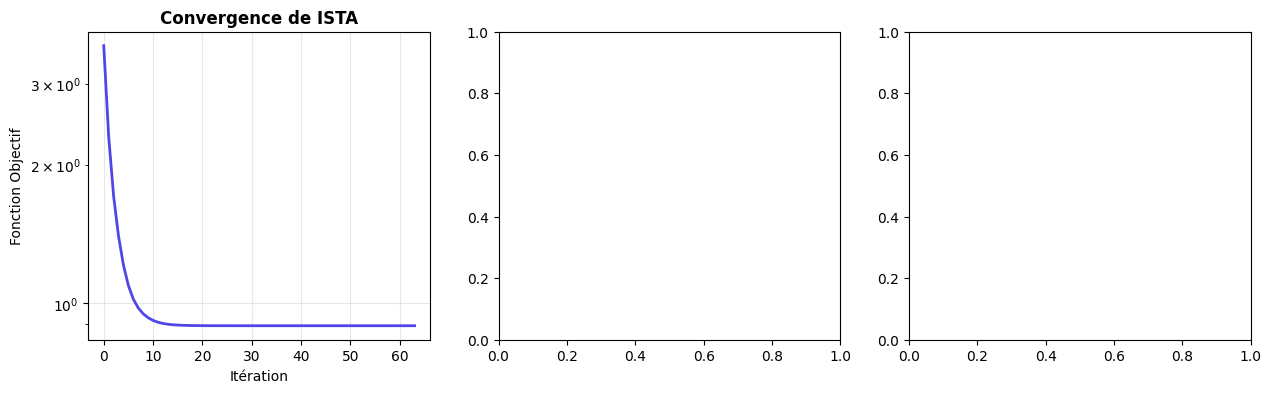

In [7]:
# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Graphique 1: Convergence de l'objectif
axes[0].plot(objectives, linewidth=2, color='#4f46e5')
axes[0].set_xlabel('Itération')
axes[0].set_ylabel('Fonction Objectif')
axes[0].set_title('Convergence de ISTA', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')


In [8]:
# Graphique 2: Évolution de la parcimonie
axes[1].plot(sparsity_hist, linewidth=2, color='#10b981')
axes[1].axhline(y=sparsity, color='red', linestyle='--', 
                label=f'Vrai sparsity ({sparsity})')
axes[1].set_xlabel('Itération')
axes[1].set_ylabel('Nombre de coefficients non-nuls')
axes[1].set_title('Évolution de la Parcimonie', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

In [9]:
# Graphique 3: Comparaison w_true vs w_estimé
axes[2].stem(range(d), w_true, linefmt='b-', markerfmt='bo', 
             basefmt=' ', label='w_true')
axes[2].stem(range(d), w_ista, linefmt='r-', markerfmt='rx', 
             basefmt=' ', label='w_ISTA')
axes[2].set_xlabel('Index du coefficient')
axes[2].set_ylabel('Valeur')
axes[2].set_title('Comparaison des Coefficients', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ista_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graphiques sauvegardés: ista_results.png")

<Figure size 1200x600 with 0 Axes>

✓ Graphiques sauvegardés: ista_results.png



EXERCICE 3: LASSO PATH - CHEMIN DE RÉGULARISATION

⚙ Calcul du Lasso Path...


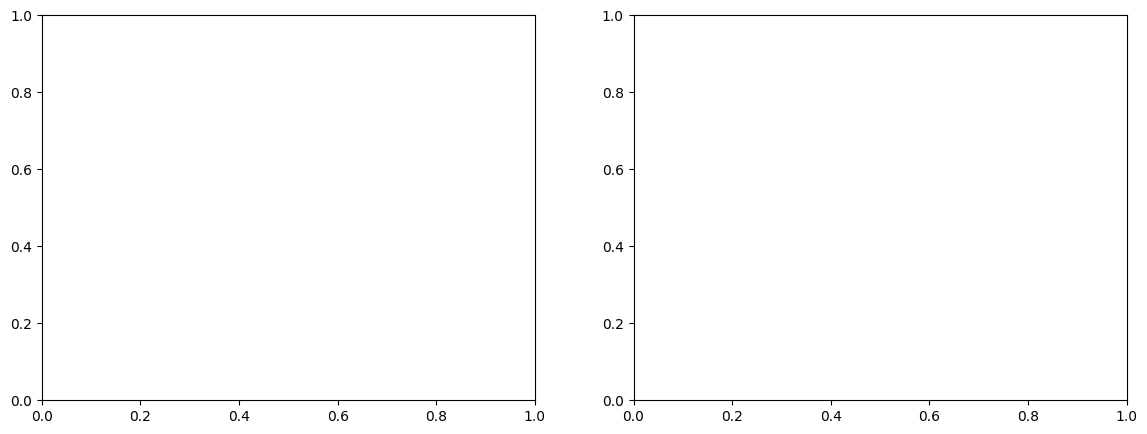

In [10]:
# ============================================================================
# PARTIE 3: ANALYSE DE LA PARCIMONIE (LASSO PATH)
# ============================================================================

print("\n" + "="*80)
print("EXERCICE 3: LASSO PATH - CHEMIN DE RÉGULARISATION")
print("="*80)

# Génération de nouvelles données pour le Lasso Path
X_path, y_path, w_true_path = generate_synthetic_data(n=100, d=20, sparsity=5)

# Plage de valeurs de alpha (lambda)
alphas = np.logspace(-4, 0, 50)
coefs = []
n_nonzeros = []

print("\n⚙ Calcul du Lasso Path...")
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-4)
    lasso.fit(X_path, y_path)
    coefs.append(lasso.coef_)
    n_nonzeros.append(np.sum(np.abs(lasso.coef_) > 1e-6))

coefs = np.array(coefs)

# Visualisation du Lasso Path
fig, axes = plt.subplots(1, 2, figsize=(14, 5))



In [11]:
# Graphique 1: Évolution des coefficients
for i in range(coefs.shape[1]):
    axes[0].plot(np.log10(alphas), coefs[:, i], linewidth=2)
axes[0].set_xlabel('log₁₀(α)', fontsize=12)
axes[0].set_ylabel('Valeur des coefficients', fontsize=12)
axes[0].set_title('Chemin du Lasso (Lasso Path)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linewidth=0.5)

# Graphique 2: Parcimonie vs alpha
axes[1].plot(np.log10(alphas), n_nonzeros, linewidth=3, 
             color='#8b5cf6', marker='o', markersize=4)
axes[1].set_xlabel('log₁₀(α)', fontsize=12)
axes[1].set_ylabel('Nombre de coefficients non-nuls', fontsize=12)
axes[1].set_title('Parcimonie vs Régularisation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lasso_path.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x600 with 0 Axes>

In [12]:
# Analyse détaillée pour différentes valeurs de alpha
print("\n📊 ANALYSE DE LA PARCIMONIE:")
print("-" * 60)
test_alphas = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1.0]
for alpha in test_alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_path, y_path)
    n_nz = np.sum(np.abs(lasso.coef_) > 1e-6)
    print(f"α = {alpha:6.4f} → {n_nz:2d} coefficients non-nuls")


📊 ANALYSE DE LA PARCIMONIE:
------------------------------------------------------------
α = 0.0001 → 20 coefficients non-nuls
α = 0.0010 → 20 coefficients non-nuls
α = 0.0100 → 18 coefficients non-nuls
α = 0.1000 →  6 coefficients non-nuls
α = 0.5000 →  5 coefficients non-nuls
α = 1.0000 →  5 coefficients non-nuls



COMPARAISON RIDGE (L2) VS LASSO (L1)


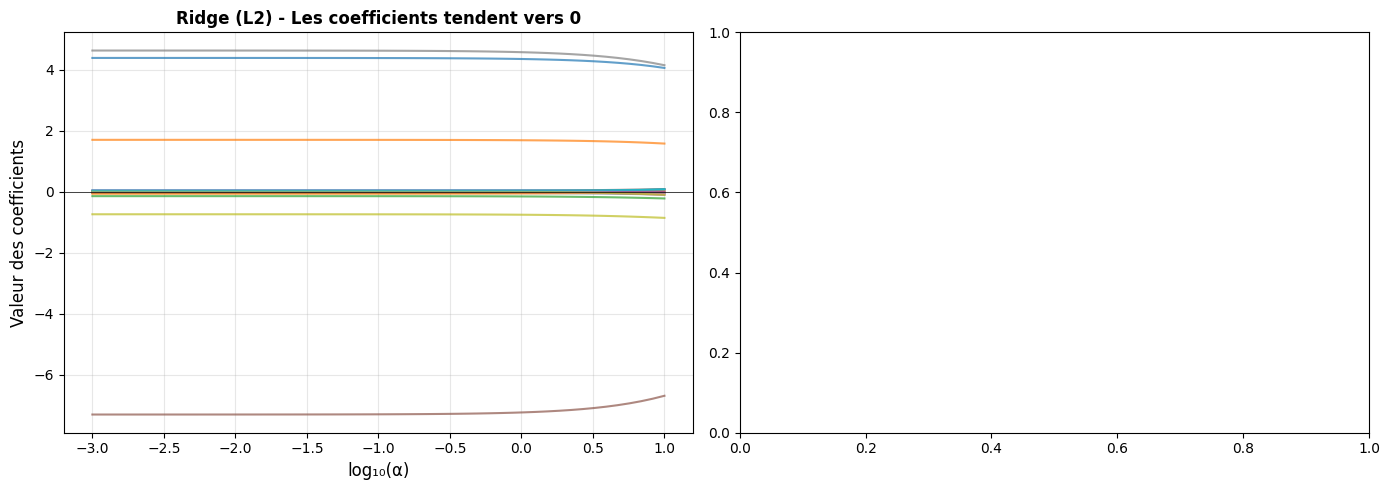

✓ Graphiques sauvegardés: ridge_vs_lasso.png

📋 DIFFÉRENCES CLÉS:
------------------------------------------------------------
RIDGE (L2):
  • Pénalité: λ||w||²₂
  • Réduit tous les coefficients proportionnellement
  • Coefficients jamais exactement nuls
  • Bon pour multicollinéarité

LASSO (L1):
  • Pénalité: λ||w||₁
  • Met certains coefficients exactement à zéro
  • Sélection automatique de variables
  • Bon pour interprétabilité et parcimonie


In [13]:
print("\n" + "="*80)
print("COMPARAISON RIDGE (L2) VS LASSO (L1)")
print("="*80)

# Comparaison visuelle
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

alphas_comp = np.logspace(-3, 1, 50)
ridge_coefs = []
lasso_coefs = []

for alpha in alphas_comp:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_path, y_path)
    ridge_coefs.append(ridge.coef_)
    
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_path, y_path)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# Ridge Path
for i in range(ridge_coefs.shape[1]):
    axes[0].plot(np.log10(alphas_comp), ridge_coefs[:, i], linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('log₁₀(α)', fontsize=12)
axes[0].set_ylabel('Valeur des coefficients', fontsize=12)
axes[0].set_title('Ridge (L2) - Les coefficients tendent vers 0', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.savefig('ridge_vs_lasso.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graphiques sauvegardés: ridge_vs_lasso.png")

print("\n📋 DIFFÉRENCES CLÉS:")
print("-" * 60)
print("RIDGE (L2):")
print("  • Pénalité: λ||w||²₂")
print("  • Réduit tous les coefficients proportionnellement")
print("  • Coefficients jamais exactement nuls")
print("  • Bon pour multicollinéarité")
print("\nLASSO (L1):")
print("  • Pénalité: λ||w||₁")
print("  • Met certains coefficients exactement à zéro")
print("  • Sélection automatique de variables")
print("  • Bon pour interprétabilité et parcimonie")


In [14]:
 #============================================================================
# PARTIE 5: APPLICATION - BREAST CANCER DATASET
# ====#========================================================================

print("\n" + "="*80)
print("TP2 - PARTIE 1: SÉLECTION DE CARACTÉRISTIQUES (BREAST CANCER)")
print("="*80)

# Chargement des données
data = load_breast_cancer()
X_cancer = data.data
y_cancer = data.target
feature_names = data.feature_names

print(f"\n✓ Dataset chargé: {X_cancer.shape[0]} échantillons, {X_cancer.shape[1]} features")

# Standardisation
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

# Régression logistique avec L1 et L2
print("\n⚙ Entraînement des modèles de régression logistique...")

# Lasso (L1)
log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=10000)
log_reg_l1.fit(X_cancer_scaled, y_cancer)

# Ridge (L2)
log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=10000)
log_reg_l2.fit(X_cancer_scaled, y_cancer)

# Analyse pour λ = 0.5 (C = 1/λ = 2)
log_reg_l1_05 = LogisticRegression(penalty='l1', C=2.0, solver='liblinear', max_iter=10000)
log_reg_l1_05.fit(X_cancer_scaled, y_cancer)

coefs_l1 = log_reg_l1_05.coef_[0]
n_eliminated = np.sum(np.abs(coefs_l1) < 1e-6)

print(f"\n📊 RÉSULTATS pour λ = 0.5 (C = 2.0):")
print(f"  • Variables éliminées: {n_eliminated}/{len(coefs_l1)}")
print(f"  • Variables conservées: {len(coefs_l1) - n_eliminated}/{len(coefs_l1)}")



TP2 - PARTIE 1: SÉLECTION DE CARACTÉRISTIQUES (BREAST CANCER)

✓ Dataset chargé: 569 échantillons, 30 features

⚙ Entraînement des modèles de régression logistique...

📊 RÉSULTATS pour λ = 0.5 (C = 2.0):
  • Variables éliminées: 10/30
  • Variables conservées: 20/30



🏆 TOP 3 VARIABLES LES PLUS PRÉDICTIVES:
  1. radius error: -3.1049
  2. worst radius: -2.5426
  3. worst texture: -2.1808


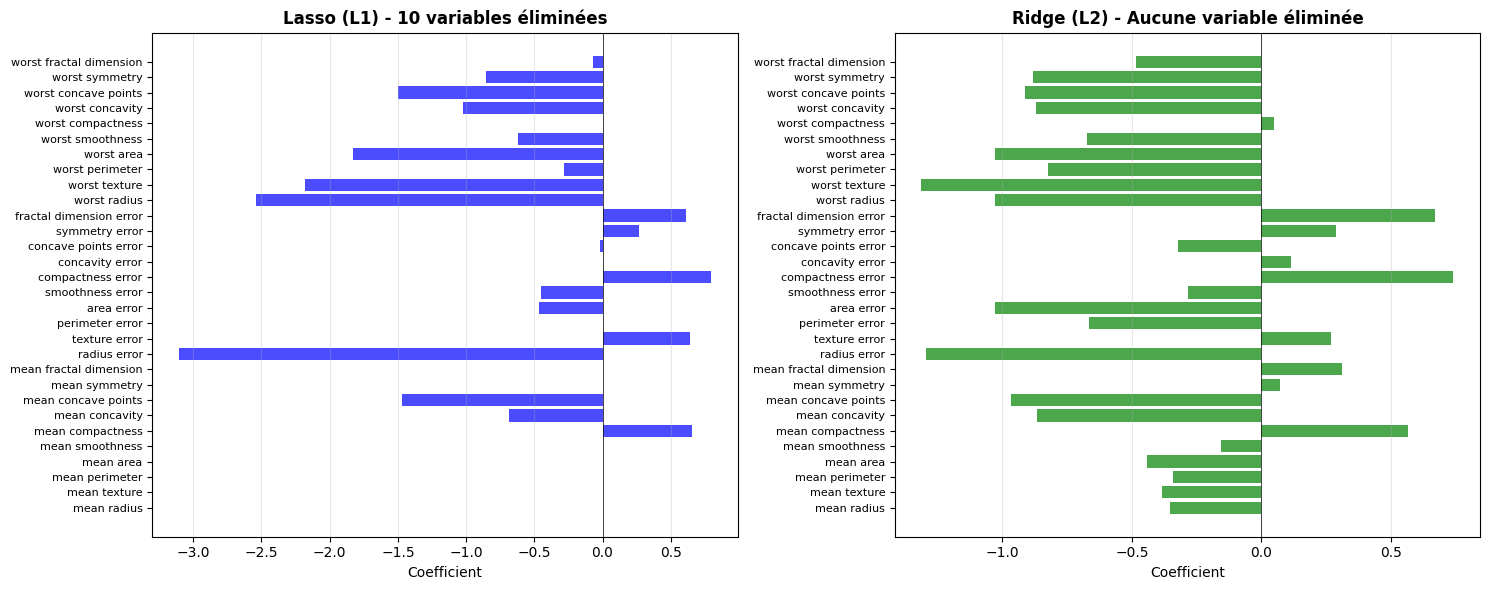

✓ Graphiques sauvegardés: breast_cancer_coefficients.png


In [15]:
# Top 3 variables les plus prédictives
top_3_indices = np.argsort(np.abs(coefs_l1))[-3:][::-1]
print(f"\n🏆 TOP 3 VARIABLES LES PLUS PRÉDICTIVES:")
for i, idx in enumerate(top_3_indices, 1):
    print(f"  {i}. {feature_names[idx]}: {coefs_l1[idx]:.4f}")

# Visualisation des coefficients
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# L1 coefficients
colors_l1 = ['red' if abs(c) < 1e-6 else 'blue' for c in coefs_l1]
axes[0].barh(range(len(coefs_l1)), coefs_l1, color=colors_l1, alpha=0.7)
axes[0].set_yticks(range(len(feature_names)))
axes[0].set_yticklabels(feature_names, fontsize=8)
axes[0].set_xlabel('Coefficient')
axes[0].set_title(f'Lasso (L1) - {n_eliminated} variables éliminées', fontweight='bold')
axes[0].axvline(x=0, color='k', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# L2 coefficients
coefs_l2 = log_reg_l2.coef_[0]
axes[1].barh(range(len(coefs_l2)), coefs_l2, color='green', alpha=0.7)
axes[1].set_yticks(range(len(feature_names)))
axes[1].set_yticklabels(feature_names, fontsize=8)
axes[1].set_xlabel('Coefficient')
axes[1].set_title('Ridge (L2) - Aucune variable éliminée', fontweight='bold')
axes[1].axvline(x=0, color='k', linewidth=0.5)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('breast_cancer_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graphiques sauvegardés: breast_cancer_coefficients.png")


TP2 - PARTIE 2: DÉBRUITAGE PAR ISTA (OLIVETTI FACES)

⚙ Chargement du dataset Olivetti Faces...
downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\MULTI MEDIA\scikit_learn_data
✓ Image chargée: (64, 64)

⚙ Débruitage en cours...
  ✓ λ = 0.01
  ✓ λ = 0.05
  ✓ λ = 0.1
  ✓ λ = 0.3


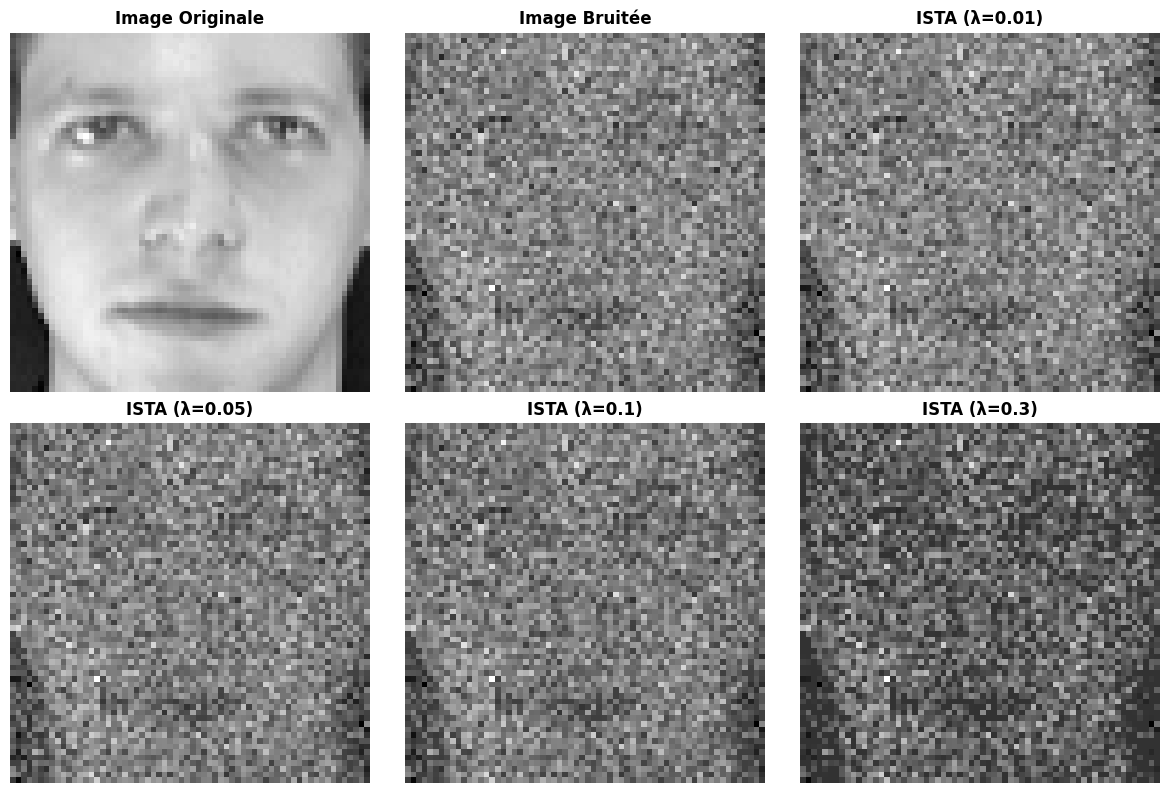

✓ Graphiques sauvegardés: image_denoising.png


In [16]:
# ============================================================================
# PARTIE 6: DÉBRUITAGE D'IMAGES PAR ISTA
# ============================================================================

print("\n" + "="*80)
print("TP2 - PARTIE 2: DÉBRUITAGE PAR ISTA (OLIVETTI FACES)")
print("="*80)

# Chargement des données
print("\n⚙ Chargement du dataset Olivetti Faces...")
faces = fetch_olivetti_faces()
image_original = faces.images[0]

# Ajout de bruit
np.random.seed(42)
noise = np.random.randn(*image_original.shape) * 0.3
image_noisy = image_original + noise

print(f"✓ Image chargée: {image_original.shape}")

# Débruitage par ISTA
def ista_denoising(y_noisy, lambda_reg, max_iter=100):
    """
    ISTA pour débruitage: min_w (1/2)||w - y_noisy||^2 + lambda||w||_1
    """
    w = y_noisy.copy().flatten()
    L = 1.0
    
    for k in range(max_iter):
        grad = w - y_noisy.flatten()
        z = w - grad / L
        w = soft_thresholding(z, lambda_reg / L)
    
    return w.reshape(y_noisy.shape)

# Débruitage avec différentes valeurs de lambda
lambdas = [0.01, 0.05, 0.1, 0.3]
denoised_images = []

print("\n⚙ Débruitage en cours...")
for lam in lambdas:
    denoised = ista_denoising(image_noisy, lam, max_iter=100)
    denoised_images.append(denoised)
    print(f"  ✓ λ = {lam}")

# Visualisation
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0, 0].imshow(image_original, cmap='gray')
axes[0, 0].set_title('Image Originale', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_noisy, cmap='gray')
axes[0, 1].set_title('Image Bruitée', fontweight='bold')
axes[0, 1].axis('off')

for i, (lam, img) in enumerate(zip(lambdas, denoised_images)):
    row = (i + 2) // 3
    col = (i + 2) % 3
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(f'ISTA (λ={lam})', fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('image_denoising.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Graphiques sauvegardés: image_denoising.png")
